
# I. Training a classifier


For this tutorial, we will use the CIFAR10 dataset.
There are 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


![CIFAR10](http://pytorch.org/tutorials/_images/cifar10.png)


In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

In [20]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

In [21]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [22]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


      bird       ship       frog      horse


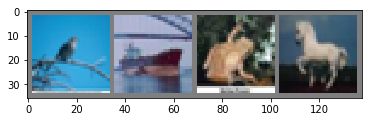

In [23]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [24]:
# Useful imports
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=7, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(18 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x14x14
        x = F.relu(self.conv1(x))
        # 18x14x14 -> 18x7x7
        x = self.pool(x)
        # 18x7x7 -> 882
        x = x.view(-1, 18 * 7 * 7)
        # 882 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [26]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

In [27]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [28]:
learning_rate = 0.001
batch_size = 32
n_epochs = 10

In [29]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batchsize for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

In [30]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statitics of the training
    
    :param  net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    

    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)
    print("number of minibatches=",n_minibatches)
    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            total_train_loss += loss.data[0]

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0

        for inputs, labels in val_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            # Forward pass
            predictions = net(inputs)
            val_loss = criterion(predictions, labels)
            total_val_loss += val_loss.data[0]
            net.train()
            
        val_history.append(total_val_loss / len(val_loader))
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [31]:
net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size, n_epochs, learning_rate)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
number of minibatches= 625
Epoch 1, 10% 	 train_loss: 2.11 took: 1.13s
Epoch 1, 20% 	 train_loss: 1.86 took: 0.69s
Epoch 1, 30% 	 train_loss: 1.69 took: 0.71s
Epoch 1, 40% 	 train_loss: 1.65 took: 0.61s
Epoch 1, 50% 	 train_loss: 1.62 took: 0.59s
Epoch 1, 60% 	 train_loss: 1.56 took: 0.59s
Epoch 1, 70% 	 train_loss: 1.56 took: 0.64s
Epoch 1, 80% 	 train_loss: 1.50 took: 0.62s
Epoch 1, 90% 	 train_loss: 1.54 took: 0.59s
Validation loss = 1.41
Epoch 2, 10% 	 train_loss: 1.41 took: 0.83s
Epoch 2, 20% 	 train_loss: 1.42 took: 0.97s
Epoch 2, 30% 	 train_loss: 1.41 took: 1.19s
Epoch 2, 40% 	 train_loss: 1.45 took: 0.74s
Epoch 2, 50% 	 train_loss: 1.39 took: 1.21s
Epoch 2, 60% 	 train_loss: 1.36 took: 0.72s
Epoch 2, 70% 	 train_loss: 1.33 took: 0.70s
Epoch 2, 80% 	 train_loss: 1.40 took: 0.73s
Epoch 2, 90% 	 train_loss: 1.35 took: 0.73s
Validation loss = 1.30
Epoch 3, 10% 	 train_loss: 1.29 took: 0.77s
Epoch 3, 20% 	

/Users/codeur/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


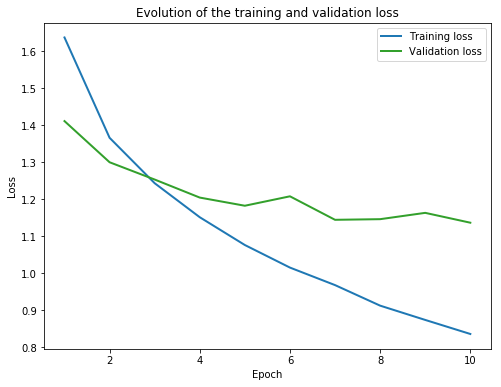

In [32]:
plot_losses(train_history, val_history)

Gound truth:

      frog       bird       bird       ship


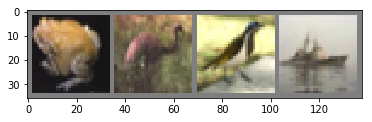

In [33]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("Gound truth:\n")

print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [34]:
outputs = net(Variable(images))
print(outputs.size())

torch.Size([4, 10])


Predicted:

      frog       deer       bird       ship


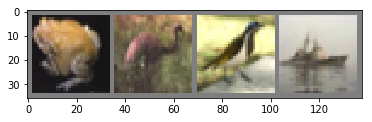

In [35]:
_, predicted = torch.max(outputs.data, 1)

print("Predicted:\n")
imshow(torchvision.utils.make_grid(images))

print(' '.join('{:>10}'.format(classes[predicted[j]]) for j in range(test_batch_size)))

In [36]:
def dataset_accuracy(net, data_loader, name=""):
    correct = 0
    total = 0
    for data in data_loader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    accuracy = 100 * correct / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 20000 train images: 74.34 %
Accuracy of the network on the 5000 validation images: 61.42 %
Accuracy of the network on the 5000 test images: 61.92 %


In [37]:
def accuracy_per_class(net):
    n_classes = 10
    class_correct = list(0. for i in range(n_classes))
    class_total = list(0. for i in range(n_classes))
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for data in test_loader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        print('{:<10} {:^10.2f}'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        68.44   
car          66.14   
bird         44.92   
cat          44.67   
deer         61.93   
dog          40.98   
frog         71.08   
horse        68.69   
ship         82.94   
truck        69.20   


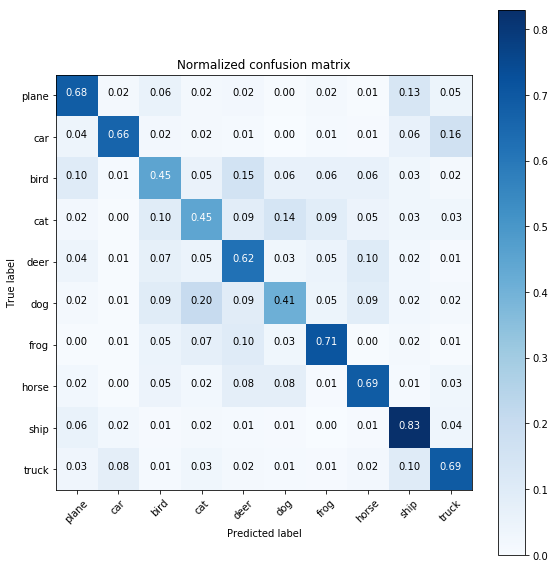

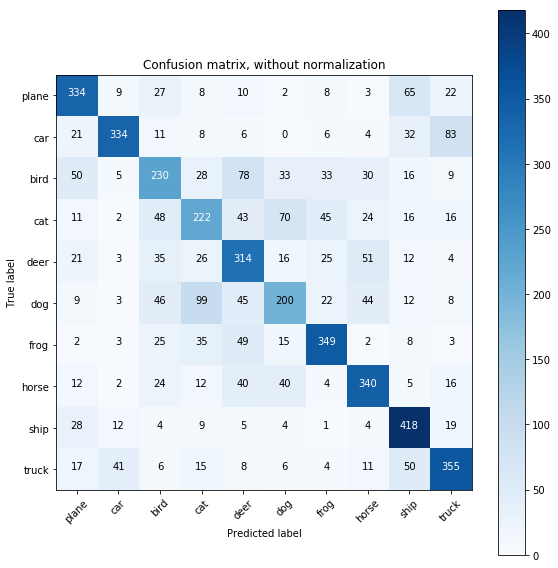

In [38]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In [39]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [40]:
out_size = get_output_size(in_size=8, kernel_size=2, stride=1, padding=0)
print(out_size)

7


In [41]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=2, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)


        self.conv2 = nn.Conv2d(18,36,kernel_size=3,stride=1,padding=1)
        self.bn=nn.BatchNorm2d(36)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=1,padding=0)

        self.flattened_size = 36 * 7 * 7
  
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x14x14
        x = F.relu((self.conv1(x)))
        # 18x14x14 -> 18x7x7
        x = self.pool(x)

        x=F.tanh(((self.conv2(x))))
        x=self.pool2(x)
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        

        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [54]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
number of minibatches= 625
Epoch 1, 10% 	 train_loss: 2.11 took: 0.96s
Epoch 1, 20% 	 train_loss: 1.82 took: 0.88s
Epoch 1, 30% 	 train_loss: 1.72 took: 0.81s
Epoch 1, 40% 	 train_loss: 1.61 took: 0.83s
Epoch 1, 50% 	 train_loss: 1.53 took: 0.81s
Epoch 1, 60% 	 train_loss: 1.51 took: 0.92s
Epoch 1, 70% 	 train_loss: 1.46 took: 0.81s
Epoch 1, 80% 	 train_loss: 1.41 took: 0.85s
Epoch 1, 90% 	 train_loss: 1.45 took: 0.84s
Validation loss = 1.32
Epoch 2, 10% 	 train_loss: 1.34 took: 0.89s
Epoch 2, 20% 	 train_loss: 1.38 took: 0.84s
Epoch 2, 30% 	 train_loss: 1.29 took: 0.84s
Epoch 2, 40% 	 train_loss: 1.32 took: 0.82s
Epoch 2, 50% 	 train_loss: 1.27 took: 0.83s
Epoch 2, 60% 	 train_loss: 1.28 took: 0.81s
Epoch 2, 70% 	 train_loss: 1.27 took: 0.88s
Epoch 2, 80% 	 train_loss: 1.26 took: 0.83s
Epoch 2, 90% 	 train_loss: 1.24 took: 0.85s
Validation loss = 1.22
Epoch 3, 10% 	 train_loss: 1.21 took: 0.87s
Epoch 3, 20% 	

### Losses Plot

/Users/codeur/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


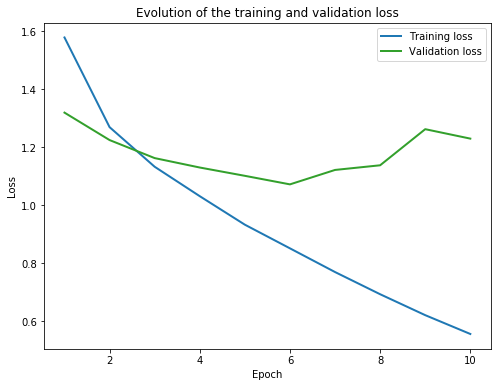

In [55]:
plot_losses(train_history, val_history)

### Accuracy of the trained model

In [56]:
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 75.19 %
Accuracy of the network on the 5000 validation images: 62.28 %
Accuracy of the network on the 5000 test images: 63.08 %


In [45]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        62.70   
car          72.08   
bird         55.27   
cat          45.27   
deer         56.41   
dog          49.80   
frog         73.73   
horse        67.68   
ship         79.96   
truck        65.89   


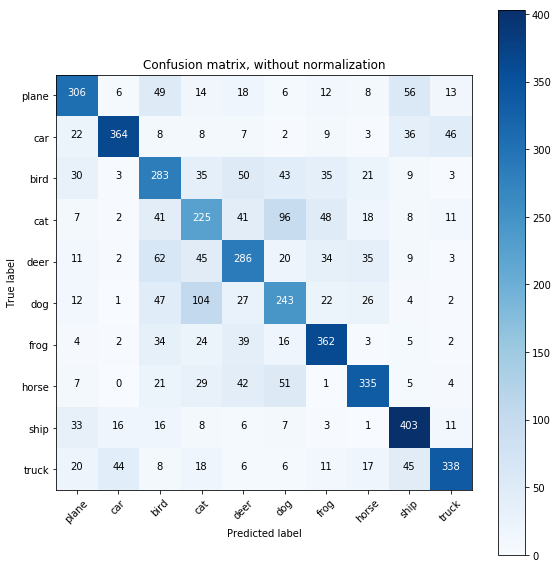

In [46]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In [47]:
import torchvision.models as models
network = models.vgg16(pretrained=True)
train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
number of minibatches= 625
Epoch 1, 10% 	 train_loss: 0.79 took: 0.98s
Epoch 1, 20% 	 train_loss: 0.78 took: 0.94s
Epoch 1, 30% 	 train_loss: 0.77 took: 0.90s
Epoch 1, 40% 	 train_loss: 0.74 took: 0.94s
Epoch 1, 50% 	 train_loss: 0.76 took: 1.01s
Epoch 1, 60% 	 train_loss: 0.78 took: 0.92s
Epoch 1, 70% 	 train_loss: 0.82 took: 1.00s
Epoch 1, 80% 	 train_loss: 0.77 took: 0.91s
Epoch 1, 90% 	 train_loss: 0.78 took: 0.94s
Validation loss = 1.02
Epoch 2, 10% 	 train_loss: 0.67 took: 0.98s
Epoch 2, 20% 	 train_loss: 0.65 took: 0.94s
Epoch 2, 30% 	 train_loss: 0.65 took: 0.93s
Epoch 2, 40% 	 train_loss: 0.71 took: 1.12s
Epoch 2, 50% 	 train_loss: 0.70 took: 1.70s
Epoch 2, 60% 	 train_loss: 0.66 took: 1.39s
Epoch 2, 70% 	 train_loss: 0.68 took: 1.05s
Epoch 2, 80% 	 train_loss: 0.73 took: 0.94s
Epoch 2, 90% 	 train_loss: 0.71 took: 1.27s
Validation loss = 1.02
Epoch 3, 10% 	 train_loss: 0.59 took: 1.05s
Epoch 3, 20% 	

/Users/codeur/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


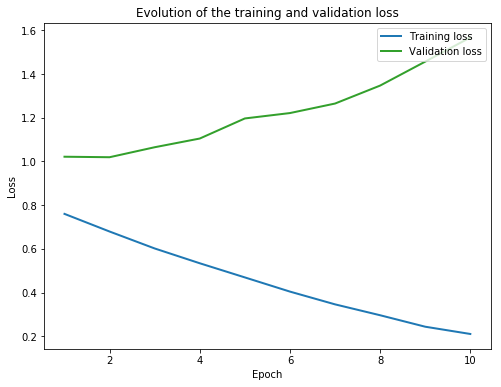

In [48]:
plot_losses(train_history, val_history)

In [49]:
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 81.06 %
Accuracy of the network on the 5000 validation images: 65.48 %
Accuracy of the network on the 5000 test images: 64.12 %


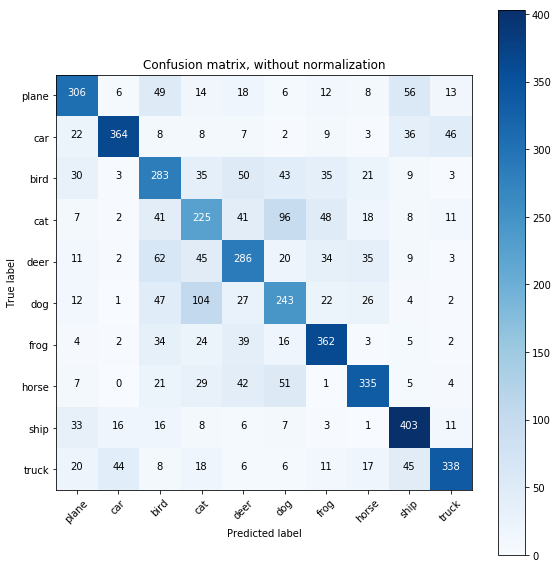

In [50]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In [51]:
network = models.resnet18()
train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
number of minibatches= 625
Epoch 1, 10% 	 train_loss: 0.61 took: 0.87s
Epoch 1, 20% 	 train_loss: 0.58 took: 0.84s
Epoch 1, 30% 	 train_loss: 0.58 took: 0.86s
Epoch 1, 40% 	 train_loss: 0.63 took: 0.85s
Epoch 1, 50% 	 train_loss: 0.65 took: 0.84s
Epoch 1, 60% 	 train_loss: 0.60 took: 0.85s
Epoch 1, 70% 	 train_loss: 0.63 took: 0.87s
Epoch 1, 80% 	 train_loss: 0.64 took: 0.85s
Epoch 1, 90% 	 train_loss: 0.64 took: 0.82s
Validation loss = 1.08
Epoch 2, 10% 	 train_loss: 0.51 took: 0.87s
Epoch 2, 20% 	 train_loss: 0.52 took: 0.83s
Epoch 2, 30% 	 train_loss: 0.50 took: 0.81s
Epoch 2, 40% 	 train_loss: 0.52 took: 0.81s
Epoch 2, 50% 	 train_loss: 0.54 took: 0.86s
Epoch 2, 60% 	 train_loss: 0.57 took: 0.82s
Epoch 2, 70% 	 train_loss: 0.52 took: 0.83s
Epoch 2, 80% 	 train_loss: 0.56 took: 0.85s
Epoch 2, 90% 	 train_loss: 0.57 took: 0.82s
Validation loss = 1.12
Epoch 3, 10% 	 train_loss: 0.44 took: 0.88s
Epoch 3, 20% 	

/Users/codeur/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


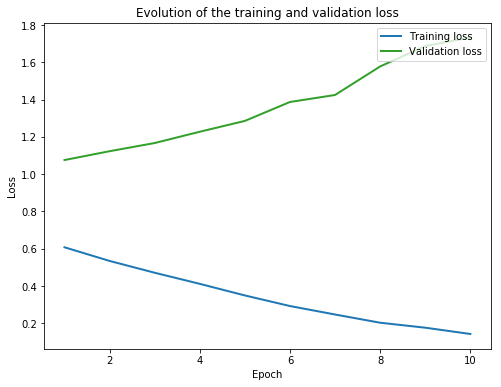

In [52]:
plot_losses(train_history, val_history)

In [53]:
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 83.77 %
Accuracy of the network on the 5000 validation images: 65.46 %
Accuracy of the network on the 5000 test images: 64.20 %
